# Introduction
In this notebook, we will implement ADMM and solve for closed-loop maps which define the SLS parameterization. We will compare the solution to the solution generated from CVXpy, comparing both the accuracy and the computation time. Answer all questions and implement the functions where there is a "todo" comment.


<!-- \newcommand{\norm}[1]{\left\lVert#1\right\rVert} -->



In [2]:
import numpy as np
import cvxpy as cp
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import multiprocessing


The SLS optimization problem we will consider is
\begin{align*}
\min_{\theta_x,\theta_u}\left\|\begin{bmatrix}
\mathbf Q^{1/2} & 0\\0  &\mathbf R^{1/2}
\end{bmatrix} \begin{bmatrix}
\theta_x \\ \theta_u
\end{bmatrix}
 \right\|_2^2 \\
 \text{such that } [I-\mathbf A, -\mathbf B]\begin{bmatrix} \theta_x \\ \theta_u \end{bmatrix}=I\,.
\end{align*}


Is the system level constraint $[I-\mathbf A, -\mathbf B]\begin{bmatrix} \theta_x \\ \theta_u \end{bmatrix}=I$ row-separable or column-separable, both, or neither?

$\color{red}{\text{answer here}}$

We will define the relevant matrices for the problem.

In [3]:
Nx = 8 # dimension of system state
Nu = 4 # dimension of control input
T  = 12 # number of time steps

# generate diagonal matrix for A
A = np.eye(Nx)*0.7
A += np.diag(np.ones(Nx-1), k=-1)*0.3
A += np.diag(np.ones(Nx-1), k=1)*0.3

# control every 2nd state
B = np.zeros((Nx, Nu))
B[np.arange(Nx/2,dtype=int)*2,np.arange(Nu)] = 1.


# cost matrices
Q = np.eye(Nx)
R = np.eye(Nu)

Let us now construct the block subdiagonal matrices $\mathbf A$ and $\mathbf B$.

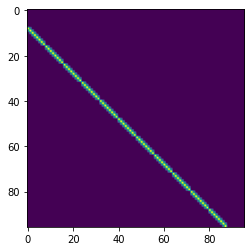

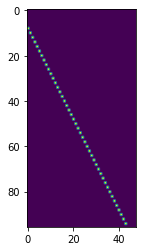

In [ ]:
def build_block_AB(A,B,T):
    '''place A on the block-SUB-diagonal of a matrix T-1 times
    place B on the block-SUB-diagonal of a matrix T-1 times'''
    # todo
    pass

calA, calB = build_block_AB(A,B,T)

# plot A to check for correct structure
plt.figure()
plt.imshow(calA)
plt.show()

# plot B to check for correct structure
plt.figure()
plt.imshow(calB)
plt.show()


Now we define the cost matrix for the norm by
\begin{align*}
\begin{bmatrix}
Q^{1/2} & & & & &\\
& \ddots & & & &\\
& & Q^{1/2} & & &\\
& & & R^{1/2} & & \\
& & & & \ddots & \\
& & & & & R^{1/2} 
\end{bmatrix}\,.
\end{align*}

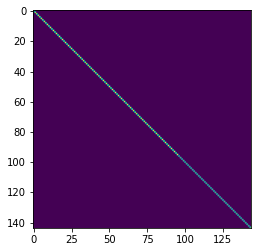

In [5]:
# compute block cost matrices from Q and R, each block is of size Nx x Nx or Nu x Nu, repeated T times
Qbar = block_diag(*[Q]*T)
Rbar = block_diag(*[R]*T)/np.sqrt(2.)
costMatrix = block_diag(Qbar,Rbar)
plt.figure()
plt.imshow(costMatrix)

Here we will build the constraint matrix. Let $d=[I-\mathbf A, -\mathbf B]$ and $f=I$ so that the constraint can be written as $d \begin{bmatrix} \theta_x \\ \theta_u \end{bmatrix} = f$.

In [6]:
f = np.eye(Nx*T)
d = np.concatenate([np.eye(Nx*T)-calA, -calB], axis=1)

## ADMM
Now we set up the ADMM algorithm. We will be solving the row and columns separately.

In [ ]:


def minimize_col_subproblem(phi,lamb,rho):
    '''Use CVXpy to solve the ADMM column subproblem.'''
    x   = cp.Variable(shape=phi.shape)
    # todo: fill in the constraints and the objective
    const = []
    obj   = []
    prob  = cp.Problem(cp.Minimize(obj),constraints=const)
    prob.solve()
    return prob.variables()[0].value
 
 
def minimize_row_subproblem(psi,lamb,rho):
    '''Use CVXpy to solve the ADMM row subproblem. Hint: rho is not needed here, and it may be helpful to enforce causality.'''
    x   = cp.Variable(shape=psi.shape)
    # todo: fill in the constraints and the objective
    const = []
    obj   = []
    prob  = cp.Problem(cp.Minimize(obj),const)
    prob.solve()
    
    return prob.variables()[0].value

def update_lamb(phi,psi,lamb):
    '''Update Lambda.'''
    # todo
    pass

def compute_primal(phi,psi):
    return np.linalg.norm(phi-psi,ord='fro')**2

def compute_dual(psi,psi_old):
    return np.linalg.norm(psi-psi_old,ord='fro')**2

def full_problem():
    x   = cp.Variable(shape=((Nx+Nu)*T,Nx*T))
    const = [ cp.matmul(d,x) - f== 0] 
    for i in range(T-1): # enforce causality
        const.append(x[Nx*i:Nx*(i+1),(i+1)*Nx:] == 0)
        const.append(x[Nx*T+i*Nu:Nx*T+(i+1)*Nu,(i+1)*Nx:] == 0)
    obj   = cp.norm(cp.matmul(costMatrix,x),'fro')**2
    prob  = cp.Problem(cp.Minimize(obj),const)
    cost = prob.solve()
    return cost,prob.variables()[0].value





# initialize variables
lamb = np.zeros(((Nx+Nu)*T,Nx*T))
psi  = np.zeros(((Nx+Nu)*T,Nx*T)) # shape of phi_x and phi_u stacked
rho  = 10 # penalty parameter

for i in range(100):
    phi         = minimize_row_subproblem(psi,lamb,rho)
    psi_old     = np.copy(psi)
    psi         = minimize_col_subproblem(phi,lamb,rho)
    lamb        = update_lamb(phi,psi,lamb)
    
    if i % 10 == 0:
        cost_primal = compute_primal(phi,psi)
        cost_dual   = compute_dual(psi,psi_old)
        print("Primal, Dual",cost_primal.round(8),cost_dual.round(8))
        if cost_primal < 1e-8 and cost_dual < 1e-8:
            break   

# here we compare the ADMM result to the full problem; they should be the same
cost,true_X = full_problem()
print(cost)
print("costs phi, psi",np.linalg.norm(costMatrix @ phi,'fro')**2,
                                   np.linalg.norm( costMatrix @ psi,'fro')**2)

Primal, Dual 98.47101477 98.47101477
Primal, Dual 0.11540007 0.25487645
Primal, Dual 0.00243041 0.00534347
Primal, Dual 9.656e-05 0.00011525
Primal, Dual 5.61e-06 1.54e-06
Primal, Dual 1.9e-07 9e-08
Primal, Dual 0.0 1e-08
160.960569522693
costs phi, psi 160.96119744598664 160.9611304736069


### Check that solution is correct

If error is greater than 1e-5, please fix your ADMM code.

In [8]:
# print error between full problem and ADMM solution
print("error",np.linalg.norm(true_X-psi,'fro')**2)

# check that closed-loop maps satisfy the system level parameterization
id = np.eye(Nx*T)
for tt in range(T-1):
    print("t=",tt,"    error",np.linalg.norm(A @ true_X[Nx*tt:Nx*(tt+1),:] + B @ true_X[Nx*T+Nu*tt:Nx*T+Nu*(tt+1),:] - true_X[Nx*(tt+1):Nx*(tt+2),:]+id[Nx*(tt+1):Nx*(tt+2),:],'fro')**2) # SLP



error 4.9003622920018096e-08
t= 0     error 4.501861245005164e-33
t= 1     error 9.774470625957485e-33
t= 2     error 6.74298022907524e-22
t= 3     error 1.1980494821898242e-21
t= 4     error 1.1979512993373426e-21
t= 5     error 1.1977538686060432e-21
t= 6     error 1.1974443491460697e-21
t= 7     error 1.1970512584154737e-21
t= 8     error 1.6804369142024925e-21
t= 9     error 5.787535150430059e-27
t= 10     error 1.4341405862317232e-32


## Construct feedback controller based on output

We will simulate a response to a nonzero initial condition and disturbances, and plot the results.

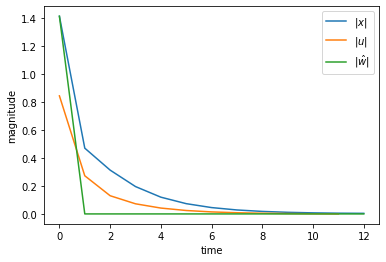

In [ ]:
# initial state
x          = np.zeros(Nx)
x[2]       = 1.
x[4]       = -1
x0         = np.copy(x)

# controller setup
phi_x      = phi[:Nx*T,:]
phi_u      = phi[Nx*T:,:]
w_hat      = np.zeros((Nx,T+1))
w_hat[:,0] = x # first disturbance is the initial condition

# track history for plotting
x_history = np.zeros((Nx,T+1))
x_history[:,0] = x
u_history = np.zeros((Nu,T))

# run simulation
for i in range(T):
    u = 0
    x_hat = 0
    for j in range(i+1):
        # todo: implement the controller using w_hat
        pass

    w_hat[:,i+1] = x - x_hat
    x = A @ x + B @ u #+ np.random.rand(Nx)*0.1
    x_history[:,i+1] = x
    u_history[:,i] = u

plt.figure()
plt.plot(np.linalg.norm(x_history,2,axis=0),label=r'$\|x\|$')
plt.plot(np.linalg.norm(u_history,2,axis=0),label=r'$\|u\|$')
plt.plot(np.linalg.norm(w_hat,2,axis=0),label=r'$\|\hat{w}\|$')
plt.legend()
plt.xlabel('time')
plt.ylabel("magnitude")
plt.show()




# Parallel Solving

Now we will solve the column and row subproblems in parallel, which will allow us to solve much larger problems. Adapt your subproblems from the earlier section to solve each column or row separately.

The code has been set up to process rows and columns either in a series (use_multiprocessing=False) and in parallel (use_multiprocessing=True). Since this problem is small, the overhead of parallelization is not necessarily worth it! It would be for a larger problem, with many processors available, for example, on a real-world system with multiple machines. You are welcome to test the multiprocessing function if you like; this is optional.

In [ ]:

def process_row(args):
    '''Minimize the j^th row, given psi, lambda_, Nx, Nu, T. Return the minimizer as a 1d array.
     The solution can be solved in closed-form; do not use CVXpy here.'''
    j,psi,lambda_,Nx,Nu,T = args
    # todo
    pass

def solve_row_subproblems(psi,lambda_,Nx,Nu,T,process_func,use_multiprocessing=False):
    dim2         = (Nu+Nx)*T
    args         = [[i,psi,lambda_,Nx,Nu,T] for i in range(dim2)]
    if use_multiprocessing:
        with multiprocessing.Pool() as pool:
            results = pool.map_async(process_func,args).get()
    else:
        results = [process_func(arg) for arg in args]

    return np.array(results)


def process_col(arg):
        '''Minimize the j^th column, given phi, lambda_, Nx, Nu, T. Return the minimizer as a 1d array.
         The solution can be solved in closed-form; do not use CVXpy here. '''
        jj,phi,lambda_,Nx,Nu,T = arg

        # todo
        pass


def solve_col_subproblems(phi,lambda_,Nx,Nu,T, process_func, use_multiprocessing=False):
    dim1         = Nx*T
    args         = [[i,phi,lambda_,Nx,Nu,T] for i in range(dim1)]
    if use_multiprocessing:
        with multiprocessing.Pool() as pool:
            results = pool.map_async(process_func,args).get()
    else:
        results = [process_func(arg) for arg in args]
    return np.array(results)

Let's test the row and column subproblems! We will compare the solution to the earlier row and column subproblems to check for correctness.

In [11]:

lamb = np.zeros(((Nx+Nu)*T,Nx*T))
psi  = np.zeros(((Nx+Nu)*T,Nx*T)) # shape of phi_x and phi_u stacked
rho  = 10

for i in range(100):
        phi         = solve_row_subproblems(psi,lamb,Nx,Nu,T,process_row) # process rows individually
        phi_test    = minimize_row_subproblem(psi,lamb,rho) # process entire problem
        
        if np.max(np.abs(phi-phi_test)) > 1e-3: # check if solutions are close enough
            print("error:",np.linalg.norm(phi-phi_test,'fro'))
            plt.figure()
            plt.imshow(phi-phi_test)
            plt.colorbar()
            plt.show()
            raise ValueError("row subproblem not solved correctly")
        
        psi_old     = np.copy(psi)
        psi         = solve_col_subproblems(phi,lamb,Nx,Nu,T,process_col).T # process columns individually
        psi_test    = minimize_col_subproblem(phi,lamb,rho) # process entire problem
        
        if np.max(np.abs(psi-psi_test)) > 1e-3: # check if solutions are close enough
            print("error:",np.linalg.norm(psi-psi_test,'fro'))
            plt.figure()
            plt.imshow(psi-psi_test)
            plt.colorbar()
            plt.show()
            raise ValueError("col subproblem not solved correctly")
        
        lamb        = update_lamb(phi,psi,lamb)
        
        if i % 10 == 0:
            cost_primal = compute_primal(phi,psi)
            cost_dual   = compute_dual(psi,psi_old)
            print("Primal, Dual",cost_primal.round(5),cost_dual.round(5))
            if cost_primal < 1e-8 and cost_dual < 1e-5:
                break   

    

print(cost)
print("costs phi, psi",np.linalg.norm(costMatrix @ phi,'fro')**2,
                                   np.linalg.norm( costMatrix @ psi,'fro')**2)

Primal, Dual 98.47101 98.47101
Primal, Dual 0.11541 0.25489
Primal, Dual 0.00243 0.00534
Primal, Dual 0.0001 0.00012
Primal, Dual 1e-05 0.0
Primal, Dual 0.0 0.0
Primal, Dual 0.0 0.0
160.960569522693
costs phi, psi 160.96121970695046 160.9611891319452


In [12]:
# Again, check that the SLP is satisfied. Errors should be around 1e-9 or smaller.
id = np.eye(Nx*T)
for tt in range(T-1):
    print("t=",tt,"    error",np.linalg.norm(A @ phi[Nx*tt:Nx*(tt+1),:] + B @ phi[Nx*T+Nu*tt:Nx*T+Nu*(tt+1),:] - phi[Nx*(tt+1):Nx*(tt+2),:]+id[Nx*(tt+1):Nx*(tt+2),:],'fro')**2) # SLP

t= 0     error 6.226023287713992e-14
t= 1     error 2.8422609391051676e-12
t= 2     error 4.098923021819149e-10
t= 3     error 3.6329541971580457e-10
t= 4     error 1.6005673200248186e-09
t= 5     error 1.9571765981634438e-09
t= 6     error 1.3690508997345398e-09
t= 7     error 2.1395126192062808e-10
t= 8     error 1.584286230396189e-10
t= 9     error 4.376390083542652e-12
t= 10     error 4.619842006737972e-18


# Constraints

A key feature of SLS is the ability to add constraints to the closed-loop maps without losing any convexity of the optimization problem. In this section, we will add locality constraints to the optimization problems.

Let $\mathbf G$ be the adjacency matrix of $A$, that is, $\mathbf G[i,j]=1$ if $A[i,j]\ne 0$, will all other entries of $\mathbf G$ equal to zero. Locality constrained to $l$ neighbors take the form

\begin{align*}
    \text{supp } \theta_x(t,\tau) = \text{supp } \mathbf G^l\,, \qquad \text{supp } \theta_u(t,\tau) = \text{supp } (|B^\top| \text{supp }\theta_x(t,\tau)),
\end{align*}
where $\text{supp}$ refers to the support of a matrix, the set of indices with nonzero elements. Edit your minimize_col_subproblem() and minimize_row_subproblem() functions to accommodate locality constraints with locality given by "radius."

In [ ]:
G = np.zeros((Nx,Nx))
G[A!=0] = 1

def minimize_col_subproblem_constrained(phi,lamb,rho,radius): 
    '''Add support constraints to the column subproblem. Use CVXpy to solve the ADMM column subproblem.'''
    # todo
    pass
 
 
def minimize_row_subproblem_constrained(psi,lamb,rho,radius):
    '''Add support constraints to the row subproblem. Use CVXpy to solve the ADMM row subproblem.'''
    # todo
    pass

Let's run the optimization problem with the constraint. Test values of radius from 1 to 6. What do you notice about the cost and feasibility? Why does this occur?
$
\color{red}{\text{answer here}}
$

In [14]:
lamb   = np.zeros(((Nx+Nu)*T,Nx*T))
psi    = np.zeros(((Nx+Nu)*T,Nx*T)) # shape of phi_x and phi_u stacked
rho    = 10
radius = 2

for i in range(100):
    phi         = minimize_row_subproblem_constrained(psi,lamb,rho,radius)
    psi_old     = np.copy(psi)
    psi         = minimize_col_subproblem_constrained(phi,lamb,rho,radius)
    lamb        = update_lamb(phi,psi,lamb)
    
    if i % 10 == 0:
        cost_primal = compute_primal(phi,psi)
        cost_dual   = compute_dual(psi,psi_old)
        print("Primal, Dual",cost_primal.round(5),cost_dual.round(5))
        if cost_primal < 1e-8 and cost_dual < 1e-8:
            break   

    
cost,true_X = full_problem()
print(cost)
print("costs phi, psi",np.linalg.norm(costMatrix @ phi,'fro')**2,
                                   np.linalg.norm( costMatrix @ psi,'fro')**2)

Primal, Dual 109.78096 109.78096
Primal, Dual 0.0786 0.19125
Primal, Dual 0.00293 0.00097
Primal, Dual 4e-05 4e-05
Primal, Dual 0.0 0.0
Primal, Dual 0.0 0.0
Primal, Dual 0.0 0.0
160.960569522693
costs phi, psi 163.12898595981756 163.12891711820592


What do you expect to happen to the cost when an acuation delay is introduced? 
$
\color{red}{\text{answer here}}
$